In [29]:
# ---------------------------
# utilis.py scopy
# ---------------------------

def get_audio_path(audio_dir, track_name):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.

    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 'blues.00000')
    '../data/genres_original/blues/blues.00000.wav'  # Corrected example output

    """
    genre = track_name.split('.')[0]
    id = track_name.split('.')[1]  # Extract the part before the dot
    return os.path.join(audio_dir, genre, genre + '.' + id + '.wav')


def get_spectrogram_path(spectrogram_dir, track_name):
    """
    Return the path to the spectrogram given the directory where the
    spectrogram is stored and the track ID.

    Examples
    --------
    >>> import utils
    >>> SPECTROGRAM_DIR = os.environ.get('SPECTROGRAM_DIR')
    >>> utils.get_spectrogram_path(SPECTROGRAM_DIR, 'blues.00000')  # Fixed typo
    '../data/genres_original/blues/blues.00000.png'

    """
    genre = track_name.split('.')
    id = track_name.split('.')[1]  # Extract the part before the dot
    return os.path.join(spectrogram_dir, genre, genre + '.' + id + '.png')



In [30]:
# ---------------------------
# generate datasets
# ---------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
import os

tracks_csv = r"D:\Music-Classification\project_data\tracks.csv"
output_dir = r"D:\Music-Classification\resnet\data"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(tracks_csv)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['genre'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['genre'], random_state=42)

train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
valid_df.to_csv(os.path.join(output_dir, 'valid.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)

print("Splits saved to", output_dir)



Splits saved to D:\Music-Classification\resnet\data


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

# ---------------------------
# Datasets and Generator
# ---------------------------
SPECTROGRAM_DIR = r"D:\Music-Classification\dataset\Data\images_original"
CSV_DIR = r"D:\Music-Classification\resnet\data"
TRAIN_CSV = os.path.join(CSV_DIR, "train.csv")
VAL_CSV = os.path.join(CSV_DIR, "valid.csv")
TEST_CSV = os.path.join(CSV_DIR, "test.csv")

def build_label_map(df):
    labels = sorted(df['genre'].unique())
    return {label: idx for idx, label in enumerate(labels)}

def get_spectrogram_path(root_dir, track_id):
    genre, number, _ = track_id.split('.')
    fname = f"{genre}{int(number):05d}.png"
    return os.path.join(root_dir, genre, fname)

def make_image_label_list(df, label_map, root_dir):
    data = []
    for _, row in df.iterrows():
        track_id = row['track_id'] if 'track_id' in df.columns else row[0]
        img_path = get_spectrogram_path(root_dir, track_id)
        label_idx = label_map[row['genre']]
        data.append((img_path, label_idx))
    return data

def fixed_center_crop(img, left=54, top=35, right=42, bottom=35):
    # img: PIL.Image
    w, h = img.size
    return img.crop((left, top, w - right, h - bottom))

# class SpectrogramDataGenerator(Sequence): #bez resize backup
#     def __init__(self, data, batch_size=128, num_classes=10, target_size=(224, 224)):
#         self.data = data
#         self.batch_size = batch_size
#         self.num_classes = num_classes
#         self.target_size = target_size

#     def __len__(self):
#         return int(np.ceil(len(self.data) / self.batch_size))

#     def __getitem__(self, idx):
#         batch_data = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
#         images = []
#         labels = []
#         for img_path, label_idx in batch_data:
#             img = load_img(img_path, target_size=self.target_size)
#             img = img_to_array(img)
#             img = preprocess_input(img)  
#             images.append(img)
#             labels.append(label_idx)
#         images = np.array(images)
#         labels = to_categorical(labels, num_classes=self.num_classes)
#         return images, labels

class SpectrogramDataGenerator(Sequence):
    def __init__(self, data, batch_size=128, num_classes=10, target_size=(224, 224), crop_params=None):
        self.data = data
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.target_size = target_size
        self.crop_params = crop_params  # Nowe! Słownik z parametrami cropa

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = []
        labels = []
        for img_path, label_idx in batch_data:
            img = Image.open(img_path).convert('RGB')  # PIL.Image bez resize!
            if self.crop_params:
                img = fixed_center_crop(img, **self.crop_params)
            img = img.resize(self.target_size)  # Teraz resize po cropie!
            img = np.array(img)
            img = preprocess_input(img)  
            images.append(img)
            labels.append(label_idx)
        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)
        return images, labels

# Load dataframes and label map
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

label_map = build_label_map(train_df)
num_classes = len(label_map)
input_shape = (224, 224, 3)

train_data = make_image_label_list(train_df, label_map, SPECTROGRAM_DIR)
val_data = make_image_label_list(val_df, label_map, SPECTROGRAM_DIR)
test_data = make_image_label_list(test_df, label_map, SPECTROGRAM_DIR)

batch_size = 128

crop_params = {'left': 54, 'top': 35, 'right': 42, 'bottom': 35}

train_gen = SpectrogramDataGenerator(train_data, batch_size, num_classes, target_size=(224, 224), crop_params=crop_params)
val_gen = SpectrogramDataGenerator(val_data, batch_size, num_classes, target_size=(224, 224), crop_params=crop_params)
test_gen = SpectrogramDataGenerator(test_data, batch_size, num_classes, target_size=(224, 224), crop_params=crop_params)

# backup bez resize
# train_gen = SpectrogramDataGenerator(train_data, batch_size, num_classes, target_size=(224, 224))
# val_gen = SpectrogramDataGenerator(val_data, batch_size, num_classes, target_size=(224, 224))
# test_gen = SpectrogramDataGenerator(test_data, batch_size, num_classes, target_size=(224, 224))


C:\Users\mrmro\AppData\Local\Temp\ipykernel_22536\2692423944.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  track_id = row['track_id'] if 'track_id' in df.columns else row[0]


In [32]:


from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# ---------------------------
# Custom ResNet
# ---------------------------
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_custom_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# ---------------------------
# Premade Keras (Google) ResNet50
# ---------------------------

def build_resnet50(input_shape, num_classes):
    base_model = ResNet50(
        weights="imagenet",    
        include_top=False,
        input_shape=input_shape
    )
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.8)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# ---------------------------
# Premade Keras ResNet50_freze
# ---------------------------

def build_resnet50_frozen(input_shape, num_classes, dense_units=256): #, dropout_rate=0.5
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# ---------------------------
# Funkcja odmrażająca bazowy model (do warstwy 174 włącznie)
# ---------------------------
def unfreeze_base_resnet(model, resnet_layers=175):
    for layer in model.layers[:resnet_layers]:
        layer.trainable = True
    print(f"[INFO] Odmrożono pierwsze {resnet_layers} warstw (ResNet50).")
    return model

# ---------------------------
# ResNet18
# ---------------------------

from tensorflow.keras import layers, models, Input

def conv_block(x, filters, kernel_size=3, stride=1):
    y = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    return y

def res_block(x, filters, stride=1):
    shortcut = x
    y = conv_block(x, filters, stride=stride)
    y = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    out = layers.Add()([shortcut, y])
    out = layers.ReLU()(out)
    return out

def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 64, kernel_size=7, stride=2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 2 x [64]
    x = res_block(x, 64)
    x = res_block(x, 64)
    # 2 x [128]
    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)
    # 2 x [256]
    x = res_block(x, 256, stride=2)
    x = res_block(x, 256)
    # 2 x [512]
    x = res_block(x, 512, stride=2)
    x = res_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model



In [33]:
# ---------------------------
# Compile and Train
# ---------------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

input_shape = (224, 224, 3)
num_classes = 10
base_name = "CPU_resnet50__imagenet_relu_bath128_50_Adam1e-4_dropout0.8_cropedimages"

# ---------------------------
model = build_resnet50(input_shape, num_classes)
# ---------------------------

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(f"{base_name}.keras", save_best_only=True)

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.1,
#     patience=5,
#     min_lr=1e-7,
#     verbose=1
# )

history = model.fit(
    train_gen,
    epochs=100,        
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint]
)

# # Odmrażamy bazowy model (warstwy 0–174)
# model = unfreeze_base_resnet(model, resnet_layers=175)
# model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

# # Dalszy trening (fine-tuning)
# history_finetune = model.fit(
#     train_gen,
#     epochs=50,
#     validation_data=val_gen,
#     callbacks=[early_stop, checkpoint],
#     initial_epoch=10
# )


c:\Users\mrmro\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-wGcFbiTP-py3.12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 143s 16s/step - Precision: 0.1300 - accuracy: 0.1125 - loss: 3.3319 - val_Precision: 0.2500 - val_accuracy: 0.1200 - val_loss: 2.4848
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 93s 15s/step - Precision: 0.5083 - accuracy: 0.3205 - loss: 1.9680 - val_Precision: 0.0000e+00 - val_accuracy: 0.1467 - val_loss: 2.3242
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 91s 15s/step - Precision: 0.6558 - accuracy: 0.4391 - loss: 1.6344 - val_Precision: 0.0000e+00 - val_accuracy: 0.2067 - val_loss: 2.2135
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 15s/step - Precision: 0.7884 - accuracy: 0.5697 - loss: 1.3083 - val_Precision: 1.0000 - val_accuracy: 0.2600 - val_loss: 2.1010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 15s/step - Precision: 0.8597 - accuracy: 0.6451 - loss: 1.0843 - val_Precision: 0.7500 - val_accuracy: 0.2867 - val_loss: 2.0087
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 15s/step - Precision: 0.9124 - accuracy: 0.7392 - loss: 0.8543 - val_Precision: 0.7917 - val_accurac

In [34]:
import pickle

# # ---------------------------
# # Evaluate & Plot
# # ---------------------------


val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
val_prec = history.history['val_Precision']

best_epoch = np.argmax(val_acc)  #

print("------ Best Model Performance ------")
print(f"Best Epoch: {best_epoch + 1}")  
print(f"Best Val Loss: {val_loss[best_epoch]:.4f}")
print(f"Val Accuracy at Best Epoch: {val_acc[best_epoch]:.4f}")
print(f"Val Precision at Best Epoch: {val_prec[best_epoch]:.4f}")

with open(f"{base_name}.pkl", 'wb') as f:
    pickle.dump(history.history, f)

------ Best Model Performance ------
Best Epoch: 37
Best Val Loss: 1.3679
Val Accuracy at Best Epoch: 0.7000
Val Precision at Best Epoch: 0.7286


1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E6CD7EA2A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step

Test Accuracy: 0.6733
Test Precision (macro): 0.7098
Test Recall (macro): 0.6733
Test F1 Score (macro): 0.6733


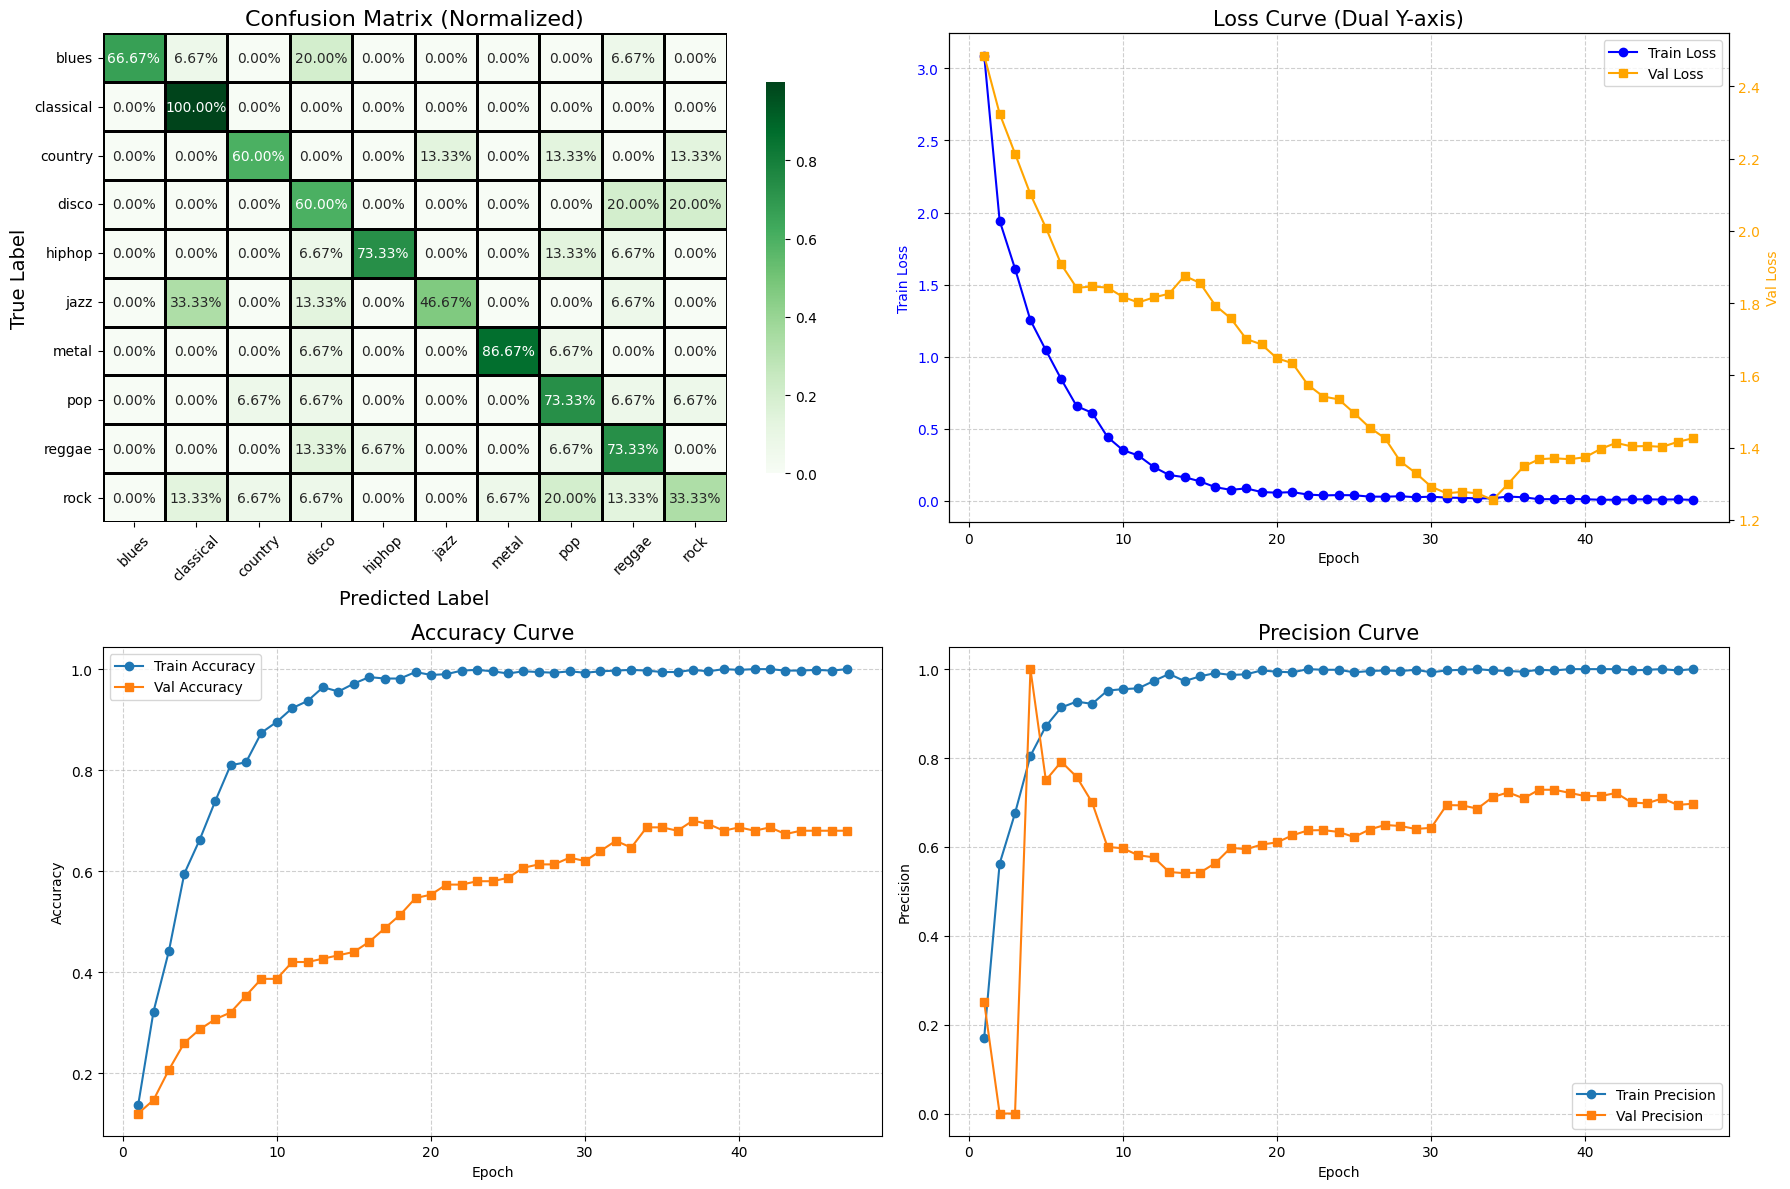

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

y_true = [label_idx for (_, label_idx) in test_data]
y_true = np.array(y_true)

y_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_probs, axis=1)

n = min(len(y_true), len(y_pred))
y_true, y_pred = y_true[:n], y_pred[:n]

test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = list(label_map.keys())

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision:.4f}")
print(f"Test Recall (macro): {test_recall:.4f}")
print(f"Test F1 Score (macro): {test_f1:.4f}")

start_epoch = 1 
epochs = range(start_epoch, len(history.history['loss']) + 1)

train_loss = history.history['loss'][start_epoch-1:]
val_loss = history.history['val_loss'][start_epoch-1:]
train_acc = history.history['accuracy'][start_epoch-1:]
val_acc = history.history['val_accuracy'][start_epoch-1:]
train_prec = history.history.get('Precision', history.history.get('precision'))[start_epoch-1:]
val_prec = history.history.get('val_Precision', history.history.get('val_precision'))[start_epoch-1:]

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

cm_norm = conf_matrix.astype('float') / (conf_matrix.sum(axis=1, keepdims=True) + 1e-8)
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap="Greens",
    xticklabels=class_names, yticklabels=class_names,
    linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8},
    ax=axs[0, 0]
)
axs[0, 0].set_xlabel('Predicted Label', fontsize=14)
axs[0, 0].set_ylabel('True Label', fontsize=14)
axs[0, 0].set_title('Confusion Matrix (Normalized)', fontsize=16)
axs[0, 0].tick_params(axis='x', rotation=45)

ax1 = axs[0, 1]
line1, = ax1.plot(epochs, train_loss, 'b-o', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Loss Curve (Dual Y-axis)', fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
line2, = ax2.plot(epochs, val_loss, 'orange', marker='s', label='Val Loss')
ax2.set_ylabel('Val Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

axs[1, 0].plot(epochs, train_acc, label='Train Accuracy', marker='o')
axs[1, 0].plot(epochs, val_acc, label='Val Accuracy', marker='s')
axs[1, 0].set_title('Accuracy Curve', fontsize=15)
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)
axs[1, 0].legend()

axs[1, 1].plot(epochs, train_prec, label='Train Precision', marker='o')
axs[1, 1].plot(epochs, val_prec, label='Val Precision', marker='s')
axs[1, 1].set_title('Precision Curve', fontsize=15)
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)
axs[1, 1].legend()

plt.tight_layout()
plt.show()



In [36]:

# import pickle

# with open('resnet18.pkl', 'rb') as f:
#     history_dict = pickle.load(f)


# val_loss = history_dict['val_loss']
# val_acc = history_dict['val_accuracy']
# val_prec = history_dict['val_Precision']

# best_epoch = np.argmax(val_prec)  # (Or argmin(val_loss) if you prefer best loss)

# print("------ Best Model Performance ------")
# print(f"Best Epoch: {best_epoch + 1}")  
# print(f"Best Val Loss: {val_loss[best_epoch]:.4f}")
# print(f"Val Accuracy at Best Epoch: {val_acc[best_epoch]:.4f}")
# print(f"Val Precision at Best Epoch: {val_prec[best_epoch]:.4f}")
